<a href="https://colab.research.google.com/github/jakeoung/ctsiren/blob/main/ctsiren.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

# from projection geometry to vectors representing a more specific geometry for each angle
# https://github.com/astra-toolbox/astra-toolbox/blob/10d87f45bc9311c0408e4cacdec587eff8bc37f8/python/astra/functions.py
def geom_2vec(proj_geom):
    # PARALLEL
    if proj_geom['Type'] == 'parallel2d':
        angles = proj_geom['ProjectionAngles']
        vectors = np.zeros([len(angles), 6])
        for i in range(len(angles)):
            # ray direction
            vectors[i, 0] = np.sin(angles[i])
            vectors[i, 1] = -np.cos(angles[i])
            
            # center of detector
            vectors[i, 2] = 0
            vectors[i, 3] = 0
            
            # vector from detector pixel (0,0) to (0,1)
            vectors[i, 4] = np.cos(angles[i]) * proj_geom['DetectorSpacingX']
            vectors[i, 5] = np.sin(angles[i]) * proj_geom['DetectorSpacingX']

    proj_geom['Vectors'] = vectors.astype(np.float32)

# generate rays for each angle, for each detector pixel
def gen_rays2d(proj_geom, vol_geom, roifactor = 1.4):
    W = proj_geom["DetectorColCount"]
    vecs = proj_geom["Vectors"]
    nangle = vecs.shape[0]
    ny, nx = vol_geom["ny"], vol_geom["nx"]
    x_dim = 2
    
    orig = np.zeros([x_dim, W, nangle], dtype=np.float32)
    dir = np.zeros([x_dim, W, nangle], dtype=np.float32)
    far = np.zeros([W, nangle], dtype=np.float32)

    # tighten_bb = false
    dist_origin = (vol_geom["maxX"] - vol_geom["minX"]) * 0.5 * roifactor

    bb_min = roifactor * np.array([vol_geom["minX"], vol_geom["minY"]])
    bb_max = roifactor * np.array([vol_geom["maxX"], vol_geom["maxY"]])

    for i in range(nangle):
        if proj_geom["Type"] == "parallel2d":
            det_center = vecs[i, 2:4]
            detU = vecs[i, 4:]
            
            detS = det_center - 0.5 * W * detU
            srcS_origin = -vecs[i,:x_dim] * dist_origin - 0.5 * W * detU + 0.5 * detU

            # ray for parallel
            ray_dir = vecs[i,:x_dim]
    
            for u in range(W):
                dir[:, u, i] = ray_dir
                orig[:, u, i] = srcS_origin + u * detU
                far[u, i] = dist_origin*2

    # Julia to Python convention
    orig = orig.transpose([2,1,0])
    dir = dir.transpose([2,1,0])
    far = far.transpose()
    print(orig.shape) # A x W x 2

    # vectorize 
    orig = orig.reshape(-1, 2)
    dir = dir.reshape(-1, 2)
    far = far.reshape(-1)

    return orig, dir, far

# generate rays
W = 256
nangle = 30
proj_geom = {}
proj_geom['Type'] = 'parallel2d'
proj_geom['DetectorColCount'] = W
proj_geom['DetectorSpacingX'] = 2.0 / W
proj_geom['ProjectionAngles'] = np.linspace(0, np.pi, nangle, endpoint=False)
geom_2vec(proj_geom)
vol_geom = {"nx":W, "ny":W, "nz":0, "minX":-1, "maxX":1,
            "minY":-1, "maxY":1, "spacingX":2/W, "spacingY":2/W}
orig, dir, far = gen_rays2d(proj_geom, vol_geom)


def sample_grid(vol_geom):
    v = vol_geom
    x = np.linspace(v["minX"]+0.5*v["spacingX"], v["maxX"]-0.5*v["spacingX"], v["nx"])
    y = np.linspace(v["maxY"]-0.5*v["spacingY"], v["minY"]+0.5*v["spacingY"], v["ny"])

    # 2D
    x = x.reshape(1, len(x))
    y = y.reshape(len(y), 1)

    xx = x.repeat(len(y), 0)
    yy = y.repeat(x.shape[1], 1)

    pts = np.vstack([xx.reshape(-1), yy.reshape(-1)])
    return pts.transpose().astype(np.float32)

pts_img = torch.tensor(sample_grid(vol_geom))
print(pts_img.shape)

(30, 256, 2)
torch.Size([65536, 2])


In [20]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate


class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        # if outermost_linear:
        final_linear = nn.Linear(hidden_features, out_features)
        
        with torch.no_grad():
            final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                            np.sqrt(6 / hidden_features) / hidden_omega_0)
            
        self.net.append(final_linear)
        
        # else:
        #     self.net.append(SineLayer(hidden_features, out_features, 
        #                               is_first=False, omega_0=hidden_omega_0))
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        # coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        output[output < 0] = 0.0 # relu
        return output 

# make network
net = Siren(2, 256, 3, 1, True)
net.cuda()

Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

(7680, 2)


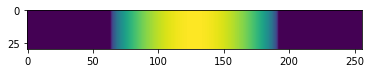

In [21]:
class Rays(Dataset):
    def __init__(self, p_data, orig, dir, far):
        super().__init__()
        self.orig = torch.FloatTensor(orig)
        self.dir = torch.FloatTensor(dir)
        self.far = torch.FloatTensor(far)
        self.p_data = torch.FloatTensor(p_data)
        
        # self.pixels = img.permute(1, 2, 0).view(-1, 1)
        # self.coords = get_mgrid(sidelength, 2)

    def __len__(self):
        return self.orig.shape[0]

    def __getitem__(self, idx):  
        return self.p_data[idx], self.orig[idx,:], self.dir[idx,:], self.far[idx]

def make_synthetic_circle(W, nangle):
    p_data_AxW = np.zeros([nangle, W])
    det_center = 0
    detU = 2.0 / W
    detS = det_center - 0.5 * W * detU + 0.5*detU
    for i in range(W):
        x = detS + i*detU
        xx = 0.25 - x**2
        if xx > 0.0:
            p_data_AxW[:, i] = 2*np.sqrt(xx)

    return p_data_AxW

print(orig.shape)
p_data_AxW = make_synthetic_circle(W, nangle)
p_data = p_data_AxW.reshape(-1)

ds = Rays(p_data, orig, dir, far)
B = 128 # batchsize
dataloader = DataLoader(ds, batch_size=B, pin_memory=True, shuffle=True, drop_last=True)

optim = torch.optim.Adam(lr=1e-4, params=net.parameters())

# visualize projection data (circle)
plt.imshow(p_data_AxW)

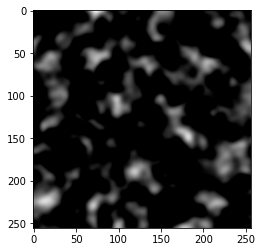

In [22]:
# visualize the initialization
img_test = net(pts_img.cuda()).detach().reshape([W,W]).cpu()
plt.imshow(np.array(img_test), cmap="gray")

In [23]:
nsamples = 256
t_steps = np.linspace(0, 1, nsamples+1, dtype=np.float32).reshape(1, -1)
nepoch = 3
lambd = 0.000001 # regularization parameter

for ep in range(nepoch):
    for (p_, orig_, dir_, far) in dataloader:

        # midpoint rule (different methods can be used such as Monte-Carlo)
        B, x_dim = orig_.shape
        t_BxN = far.reshape(-1,1) * t_steps # [(nsamples+1) x B]
        dx = (t_BxN[:,1:2] - t_BxN[:,0:1]) # ELISE: Moved this line up one because of error: dx not defined.... Don't know if this makes sense
        t_mid = t_BxN[:,:-1] + dx*0.5

        # x = o + t * d
        x = orig_.reshape(B, 1, x_dim) + dir_.reshape(B, 1, x_dim) * t_mid.reshape(B, nsamples, 1)

        # Here comes automatic differentiation
        fx_BxN = torch.squeeze(net(x.cuda()))
        p_est = torch.sum(fx_BxN * dx.cuda(), 1)
        
        loss_ = ((p_est - p_.cuda())**2).mean()

        # regularization
        # loss_ += lambd * torch.sum(torch.sqrt(torch.abs(fx_BxN[:,1:] - fx_BxN[:,0:-1]) + 1e-8)) / B
        
        optim.zero_grad()
        loss_.backward()
        optim.step()
    
    print(ep, loss_)

0 tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
1 tensor(3.9060e-05, device='cuda:0', grad_fn=<AddBackward0>)
2 tensor(4.7741e-05, device='cuda:0', grad_fn=<AddBackward0>)


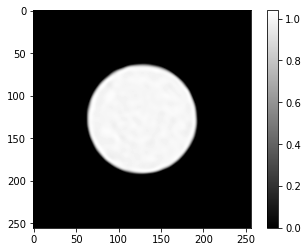

In [24]:
img_test = net(pts_img.cuda()).detach().reshape([W,W]).cpu()
plt.imshow(np.array(img_test), cmap="gray")
plt.colorbar()

In [18]:
torch.squeeze(net(x.cuda())).shape

torch.Size([128, 256])